# MRI - Alzheimer Stage Classifier
### by Haim Elbaz & Asaf Levi


## Introduction
The goal of this project is to provide a tool to classify MRI images of alzheimer patients into the different stages of the disease, characterized by dementia severity levels. 

To accomplish this, We will build a CNN model using PyTorch and train it with data obtained from kaggle:

https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images


## Data Description

## Data Praparation & Preprocessing

The dataset is already split into a train & test sub-sets. 
Within the directories of these sets, the images are arranged in subdirectories named after the class. The image file name indicates an image's unique ID. 

PyTorch's ImageFolder dataset subclass fits exactly this arrangement. 

In [2]:
import matplotlib.pyplot as plt
import torch
import numpy as np
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from helper import show_images
from torchsummary import summary

In [3]:
TRAINPATH = "Alzheimer_s Dataset/train/"
TESTPATH  = "Alzheimer_s Dataset/train/"

# Making code compatible with either M1, Cuda or CPU
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
print(f"Chosen device: {device}")

Chosen device: mps


In [4]:
transformer = transforms.Compose([transforms.Resize((208, 176)),
                                transforms.CenterCrop((188, 156)),
                                transforms.ToTensor()])
train_dataset = datasets.ImageFolder(TRAINPATH, transform=transformer)
class_to_idx = train_dataset.class_to_idx
idx_to_class = {v: k for k, v in class_to_idx.items()}

We would like to keep the test set for testing purposes. Therefore, we will split the training dataset into training and validation datasets, so that 20% of training data will be used for validation.

In [5]:
total_train_size = len(train_dataset)
print(f"Total train size: {total_train_size}")

validation_set_size = int(total_train_size * 0.2)
print(f"Validation set size: {validation_set_size}")

training_set_size = total_train_size - validation_set_size
print(f"Training set size: {training_set_size}")

training_set, validation_set = torch.utils.data.random_split(train_dataset, [training_set_size, validation_set_size])

assert validation_set_size == len(validation_set), "Validation size mismatch"
assert training_set_size == len(training_set), "Training size mismatch"
assert training_set_size + validation_set_size == total_train_size, "Dataset size mismatch after split"


Total train size: 5121
Validation set size: 1024
Training set size: 4097


In [6]:
train_loader = DataLoader(training_set, batch_size=32, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=32, shuffle=True)

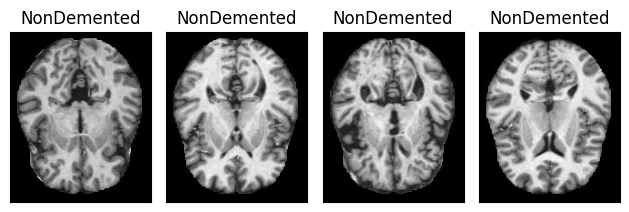

In [7]:
img, labels = next(iter(train_loader))
show_images([img[i] for i in range(4)], labels, idx_to_class)

### Pooling layer ideas
https://link.springer.com/article/10.1007/s00521-022-06953-8

"Pooling in convolutional neural networks for medical image analysis: a survey and an empirical study"


### Medical image analysis
https://link.springer.com/article/10.1007/s10916-018-1088-1


https://rdcu.be/dgvzI

"Medical Image Analysis using Convolutional Neural Networks: A Review"




### MRI Specific
https://www.sciencedirect.com/science/article/pii/S0933365716305206?casa_token=5tByST2VQV0AAAAA:0xn4a1oH7qP7xLVQ8qK9Py7pzZ8s_cDKEW2PuOQVENX_krGGj4xc2DUTQdk_FVsr9bfXYiXJJbC9


"Deep convolutional neural networks for brain image analysis on magnetic resonance imaging: a review"






In [8]:
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.conv1 = nn.Conv2d(3, 6, 3, 2, padding=1)
      self.maxpool1 = nn.MaxPool2d(3, stride=2)
      self.conv2 = nn.Conv2d(6, 46, 3, 2, padding=1)
      self.maxpool2 = nn.MaxPool2d(2, stride=2)
      self.relu1 = nn.ReLU()
      self.flat = nn.Flatten()
      self.fc1 = nn.Linear(4554, 16)
      self.fc2 = nn.Linear(16, 4)
        
    def forward(self, x):
      x = self.conv1(x)
      x = self.maxpool1(x)
      x = self.conv2(x)
      x = self.maxpool2(x)
      x = self.relu1(x)
      x = self.flat(x)
      x = self.fc1(x)
      x = self.fc2(x)
      return x
summary(Net(), input_size=(3, 188, 156))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 94, 78]             168
         MaxPool2d-2            [-1, 6, 46, 38]               0
            Conv2d-3           [-1, 46, 23, 19]           2,530
         MaxPool2d-4            [-1, 46, 11, 9]               0
              ReLU-5            [-1, 46, 11, 9]               0
           Flatten-6                 [-1, 4554]               0
            Linear-7                   [-1, 16]          72,880
            Linear-8                    [-1, 4]              68
Total params: 75,646
Trainable params: 75,646
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.34
Forward/backward pass size (MB): 0.67
Params size (MB): 0.29
Estimated Total Size (MB): 1.30
----------------------------------------------------------------


Cross Entropy Loss is a good loss function for classification tasks, as it heavily penalizes false predictions that the model was very confident in. 

In [11]:
MyCNN = Net().to(device)
loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(MyCNN.parameters(), lr=0.001, momentum=0.9)

n_epochs = 10
epochs = range(n_epochs)
train_loss_curve = list()
validation_loss_curve = list()

for epoch in range(n_epochs):
    epoch_train_loss = 0.0
    epoch_validation_loss = 0.0
    
    accuracy = 0
    count = 0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        y_pred = MyCNN(inputs)
        train_loss = loss_function(y_pred, labels)
        train_loss.backward()
        optimizer.step()    
        epoch_train_loss += train_loss.item() * inputs.size(0) 
        
        y_pred = MyCNN(inputs)
    accuracy += (torch.argmax(y_pred, 1) == labels).float().sum()
    count += len(labels)
        
        
    for inputs, labels in validation_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_pred = MyCNN(inputs)
        validation_loss = loss_function(y_pred, labels)
        epoch_validation_loss += train_loss.item() * inputs.size(0) 
    
    train_loss_curve.append(epoch_train_loss / len(train_loader.sampler))
    validation_loss_curve.append(epoch_validation_loss / len(validation_loader.sampler))
    
    
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        y_pred = MyCNN(inputs)
        accuracy += (torch.argmax(y_pred, 1) == labels).float().sum()
        count += len(labels)
    
    accuracy /= count
    
    print("Epoch %d: model accuracy %.2f%%" % (epoch, accuracy * 100))
    print(f"Epoch {epoch}: avg. loss {train_loss_curve[-1]}")
 
torch.save(MyCNN.state_dict(), "mri_model.pth")

Epoch 0: model accuracy 50.17%
Epoch 0: avg. loss 1.066643425043193
Epoch 1: model accuracy 50.17%
Epoch 1: avg. loss 1.0318904360940406
Epoch 2: model accuracy 50.29%
Epoch 2: avg. loss 1.0250157049175352
Epoch 3: model accuracy 50.20%
Epoch 3: avg. loss 1.013225715524661
Epoch 4: model accuracy 51.37%
Epoch 4: avg. loss 1.0014833615470404
Epoch 5: model accuracy 53.73%
Epoch 5: avg. loss 0.9844988994200345
Epoch 6: model accuracy 54.78%
Epoch 6: avg. loss 0.9638209578349063
Epoch 7: model accuracy 52.95%
Epoch 7: avg. loss 0.9344976989851075
Epoch 8: model accuracy 53.29%
Epoch 8: avg. loss 0.9195181711260679
Epoch 9: model accuracy 56.49%
Epoch 9: avg. loss 0.9219238807260627


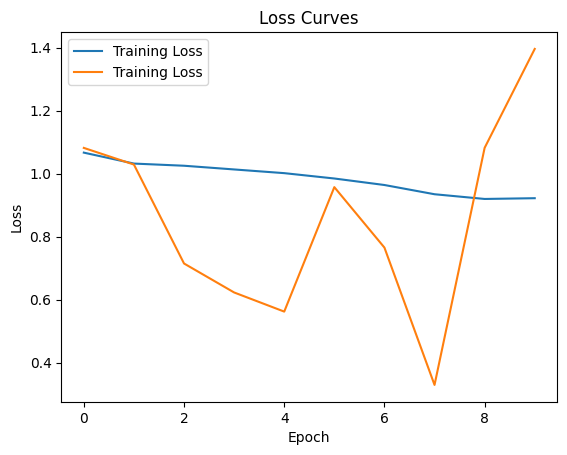

In [13]:
import matplotlib.pyplot as plt

# Plot the loss curve against the number of iterations
plt.plot(range(len(train_loss_curve)), train_loss_curve, label='Training Loss')
plt.plot(range(len(validation_loss_curve)), validation_loss_curve, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()
plt.show()


387